<a href="https://colab.research.google.com/github/gosaitos/Computer_vision/blob/main/Edge_detection_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.image import imread
import cv2

In [ ]:
img = cv2.imread("aizen.jpg",cv2.IMREAD_GRAYSCALE)

In [ ]:
def show_img(images,titles):
    n = len(images)
    fig,ax = plt.subplots(1,n,figsize=(8,8))
    for i,axx in enumerate(ax):
        axx.imshow(images[i],cmap='grey')
        axx.set_title(titles[i])
        axx.axis("off")

    plt.tight_layout()
    plt.show()

# FILTERS : ROBERT AND PREWITT

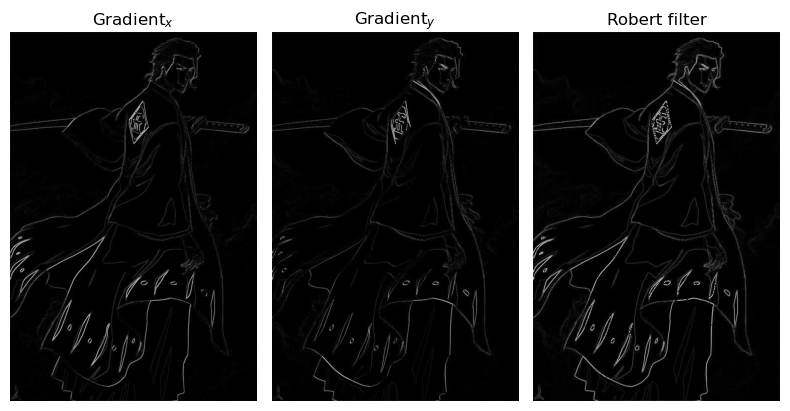

In [ ]:
# ROBERT filter
def robert_filter(img):
    rob_x = np.array([[1,0],[0,-1]])
    rob_y = np.array([[0,1],[-1,0]])

    grad_x = cv2.filter2D(img,cv2.CV_64F,rob_x)
    grad_y = cv2.filter2D(img,cv2.CV_64F,rob_y)

    robert_filt = np.uint8(np.sqrt(np.square(grad_x)+np.square(grad_y)))

    return abs(grad_x),abs(grad_y),robert_filt

grad_x,grad_y,res = robert_filter(img)
show_img([grad_x,grad_y,res],["Gradient$_x$","Gradient$_y$","Robert filter"])

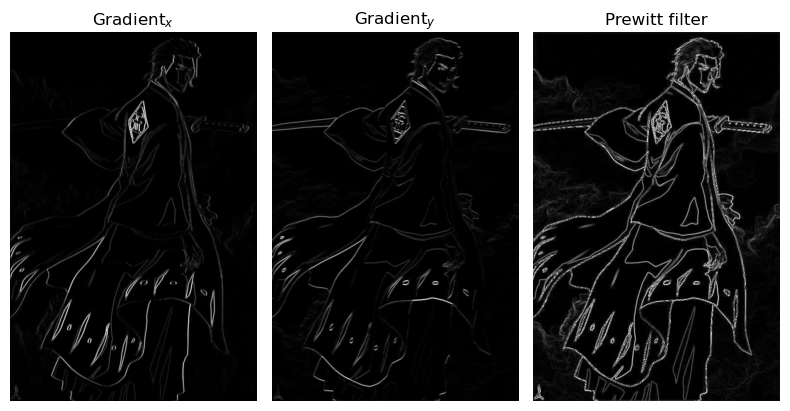

In [ ]:
# PREWITT filter
def prewitt_filter(img):
    pr_x = np.array([[-1,0,1],[-1,0,1],[-1,0,1]])
    pr_y = np.array([[-1,-1,-1],[0,0,0],[1,1,1]])

    grad_x = cv2.filter2D(img,cv2.CV_64F,pr_x)
    grad_y = cv2.filter2D(img,cv2.CV_64F,pr_y)

    pre_filt = np.uint8(np.sqrt(np.square(grad_x)+np.square(grad_y)))

    return abs(grad_x),abs(grad_y),pre_filt

grad_x,grad_y,res = prewitt_filter(img)
show_img([grad_x,grad_y,res],["Gradient$_x$","Gradient$_y$","Prewitt filter"])

# CANNY EDGE DETECTION

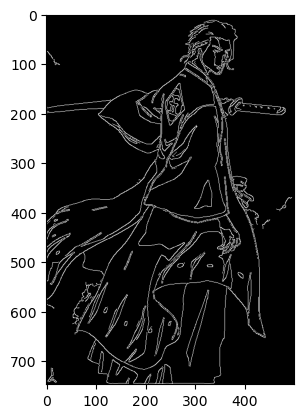

In [ ]:
#Builtin
canny = cv2.Canny(img,50,150,(3,3))
plt.imshow(canny,cmap='grey')

# Manual
Noise reduction;
Gradient calculation;
Non-maximum suppression;
Double threshold;
Edge Trackimng by Hysteresis.

In [ ]:
#Gaussian blurring
def gauss_blur(img,ks,sigma):
    size = ks//2
    x, y = np.mgrid[-size:size+1, -size:size+1]

    const = 1 / (2.0 * np.pi * sigma**2)
    g =  np.exp(-((x**2 + y**2) / (2.0*sigma**2))) * const
    g /= g.sum()
    return g

gauss_kernel = gauss_blur(img,5,1)
new_img = cv2.filter2D(img,-1,gauss_kernel)

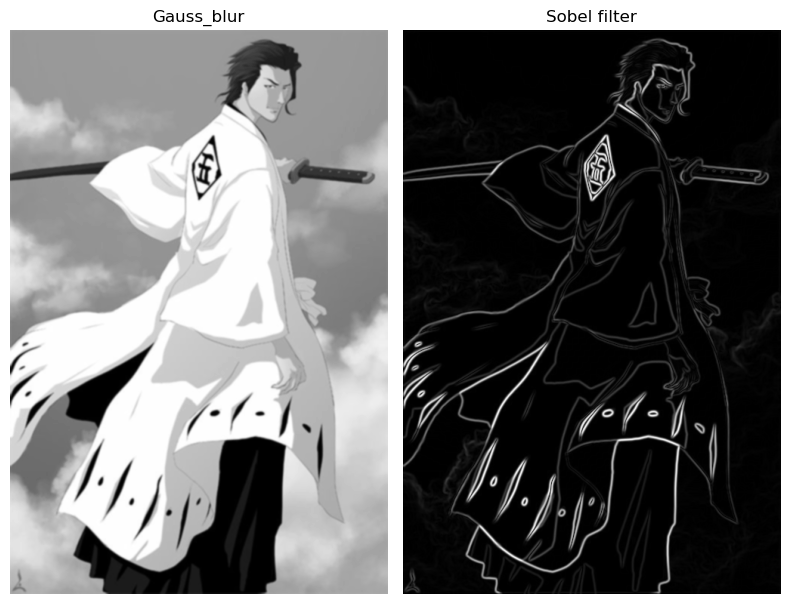

In [ ]:
def sobel_filters(img):
    Kx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], np.float32)
    Ky = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], np.float32)

    Ix = cv2.filter2D(img,cv2.CV_64F,Kx)

    Iy = cv2.filter2D(img,cv2.CV_64F,Ky)

    G =  np.hypot(Ix, Iy)
    G = G / G.max() * 255
    theta = np.arctan2(Iy, Ix)

    return (G, theta)

res,theta = sobel_filters(new_img)
show_img([new_img,res],["Gauss_blur","Sobel filter"])

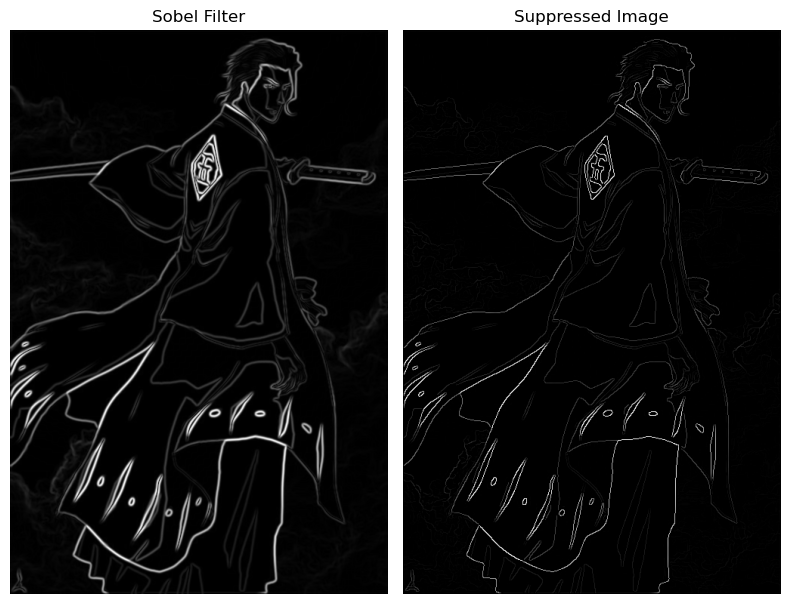

In [ ]:
def non_max_suppression(img, D):
    M, N = img.shape
    Z = np.zeros((M,N), dtype=np.int32)
    angle = D * 180. / np.pi
    angle[angle < 0] += 180

    for i in range(1,M-1):
        for j in range(1,N-1):
            try:
                q = 255
                r = 255

               #angle 0
                if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):
                    q = img[i, j+1]
                    r = img[i, j-1]
                #angle 45
                elif (22.5 <= angle[i,j] < 67.5):
                    q = img[i+1, j-1]
                    r = img[i-1, j+1]
                #angle 90
                elif (67.5 <= angle[i,j] < 112.5):
                    q = img[i+1, j]
                    r = img[i-1, j]
                #angle 135
                elif (112.5 <= angle[i,j] < 157.5):
                    q = img[i-1, j-1]
                    r = img[i+1, j+1]

                if (img[i,j] >= q) and (img[i,j] >= r):
                    Z[i,j] = img[i,j]
                else:
                    Z[i,j] = 0

            except IndexError as e:
                pass

    return Z

Suppressed_img = non_max_suppression(res,theta)
show_img([res,Suppressed_img],['Sobel Filter','Suppressed Image'])


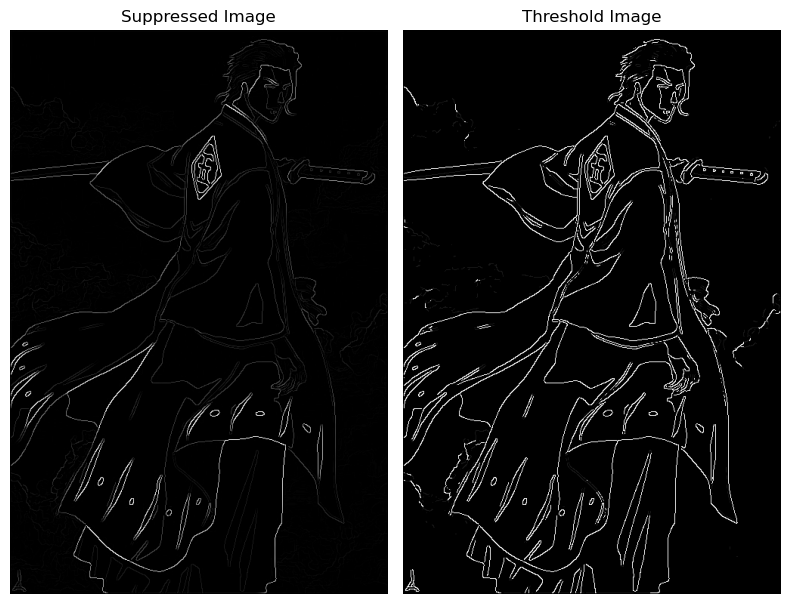

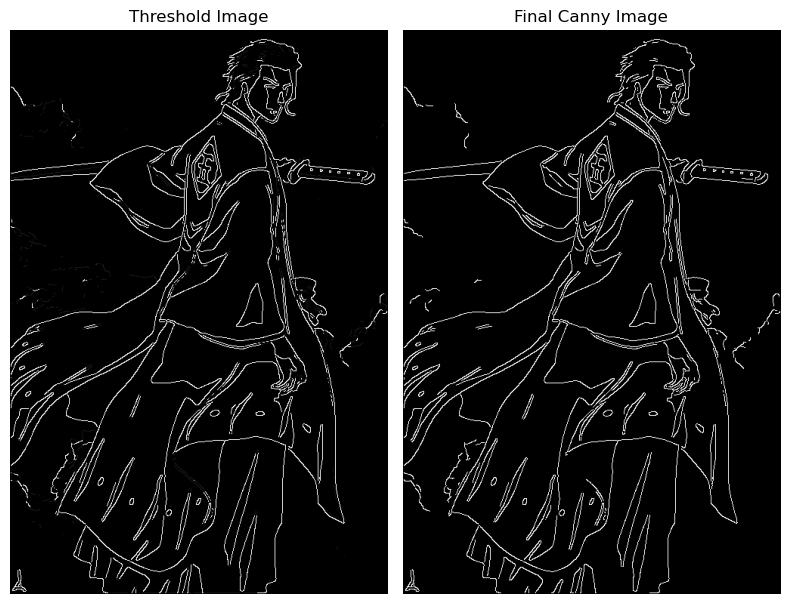

In [ ]:

def threshold(img, lowThresholdRatio=0.05, highThresholdRatio=0.09):
    highThreshold = img.max() * highThresholdRatio
    lowThreshold = img.max() * lowThresholdRatio

    M, N = img.shape
    res = np.zeros((M, N), dtype=np.int32)

    weak = np.int32(25)
    strong = np.int32(255)

    # Classify pixels
    strong_i, strong_j = np.where(img >= highThreshold)
    zeros_i, zeros_j = np.where(img < lowThreshold)
    weak_i, weak_j = np.where((img < highThreshold) & (img >= lowThreshold))

    # Assign pixel values
    res[strong_i, strong_j] = strong
    res[weak_i, weak_j] = weak

    return (res, weak, strong)

# Hysteresis function
def hysteresis(img, weak, strong=255):
    M, N = img.shape
    img_copy = img.copy()

    for i in range(1, M-1):
        for j in range(1, N-1):
            if img_copy[i, j] == weak:
                if np.any(img_copy[i-1:i+2, j-1:j+2] == strong):
                    img_copy[i, j] = strong
                else:
                    img_copy[i, j] = 0

    return img_copy

# Apply thresholding
thres_img, wk, strng = threshold(Suppressed_img)
show_img([Suppressed_img, thres_img], ['Suppressed Image', 'Threshold Image'])

# Apply hysteresis
Fin_img = hysteresis(thres_img, wk, strng)
show_img([thres_img, Fin_img], ['Threshold Image', 'Final Canny Image'])


***Laplacian of gaussian***

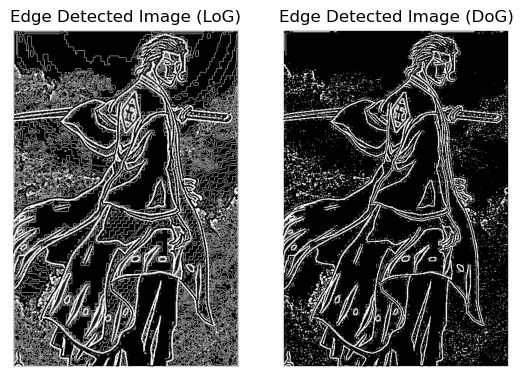

In [ ]:
def gauss_blur(img, ks, sigma):
    size = ks // 2
    x, y = np.mgrid[-size:size+1, -size:size+1]

    const = 1 / (2.0 * np.pi * sigma**2)
    g = np.exp(-((x**2 + y**2) / (2.0 * sigma**2))) * const
    g /= g.sum()
    return g

def apply_convolution(image, kernel):
    h, w = image.shape
    kh, kw = kernel.shape
    pad = kh // 2
    padded_img = np.pad(image, pad, mode='constant', constant_values=0)
    result = np.zeros_like(image)

    for i in range(h):
        for j in range(w):
            result[i, j] = np.sum(padded_img[i:i+kh, j:j+kw] * kernel)
    return result

def laplacian(image):
    kernel = np.array([[0, 1, 0],
                        [1, -4, 1],
                        [0, 1, 0]])
    return apply_convolution(image, kernel)

def laplacian_of_gaussian(image, sigma):
    gauss_kernel = gauss_blur(image, 5, sigma)
    blurred_img = apply_convolution(image, gauss_kernel)
    log_image = laplacian(blurred_img)
    return log_image


def difference_of_gaussians(image, sigma):
    sigma1 = sigma * np.sqrt(2)
    sigma2 = sigma / np.sqrt(2)

    blurred_image_1 = apply_gaussian_blur(image, sigma1)
    blurred_image_2 = apply_gaussian_blur(image, sigma2)

    dog_image = blurred_image_1 - blurred_image_2
    return dog_image

sigma = 1.4
dog_result = difference_of_gaussians(img, sigma)
log_result = laplacian_of_gaussian(img, sigma)

plt.subplot(121)
plt.imshow(log_result, cmap='gray')
plt.title("Edge Detected Image (LoG)")
plt.axis('off')
plt.subplot(122)
plt.imshow(dog_result, cmap='gray')
plt.title("Edge Detected Image (DoG)")
plt.axis('off')

plt.show()
